# Scaling up MobileNetV3Small for evaluation

This is the part 3 of three-part series:
1. `Model selection`
2. `Fine-tuning`
3. `Evaluation`

## What we are going to do

We're going to go through the following:
* Train a feature extraction transfer learning model on Covid-19 CXR images.
    * The total 13,808 images have 80-20 split (training images 11,045 - covid 2,892/normal 8,153, test images 2,763 - covid 724/normal 2,039)
* Fine-tune feature extraction model with class-weights technique
* Evaluate the performance of the model
* Make predictions with the model on custom CXR images

We start by importing the required dependencies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import zipfile
import pathlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

## Load the data and visualize it

Just as reminder how the file structure looks like:

```
Example for file structure

covid_radiography_all_data <- top level folder
└───train <- training images
│   └───covid
│   │   │   covid-1.jpg
│   │   │   covid-2.jpg
│   │   │   ...      
│   └───normal
│       │   normal-1.jpg
│       │   normal-2.jpg
│       │   ...
│   
└───test <- testing images
│   └───covid
│   │   │   covid-50.jpg
│   │   │   covid-51.jpg
│   │   │   ...      
│   └───normal
│       │   normal-50.jpg
│       │   normal-51.jpg
│       │   ...    
```

In [3]:
# Import data and unzip it
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/covid_radiography_all_data.zip')
ref.extractall()
ref.close()

In [4]:
# Walk through directories
dir_path = 'covid_radiography_all_data'

for root, dirnames, filenames in os.walk(dir_path):
    print(f'Number of {len(dirnames)} directories and {len(filenames)} files in path {root}')

Number of 2 directories and 0 files in path covid_radiography_all_data
Number of 2 directories and 0 files in path covid_radiography_all_data/train
Number of 0 directories and 2892 files in path covid_radiography_all_data/train/covid
Number of 0 directories and 8153 files in path covid_radiography_all_data/train/normal
Number of 2 directories and 0 files in path covid_radiography_all_data/test
Number of 0 directories and 724 files in path covid_radiography_all_data/test/covid
Number of 0 directories and 2039 files in path covid_radiography_all_data/test/normal


In [5]:
# Set train and test directory paths
train_dir = 'covid_radiography_all_data/train'
test_dir = 'covid_radiography_all_data/test'

In [6]:
# Create function to view a random image
def view_random_image(target_dir, target_class):
  # setup target directory
  target_folder = target_dir + "/" +target_class
  print(target_folder)

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  
  if target_class == 'normal':
        print(f'Normal image shape: {img.shape}')  # show the shape of the image
  if target_class == 'covid':
    print(f'Covid image shape: {img.shape}')

  return img

covid_radiography_all_data/train/normal
Normal image shape: (299, 299)
covid_radiography_all_data/train/covid
Covid image shape: (299, 299)


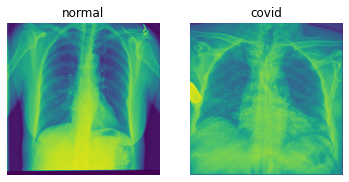

In [7]:
# View a random images from both classes
plt.figure()
plt.subplot(1, 2, 1)
normal_img = view_random_image(target_dir=train_dir,
                        target_class='normal')
plt.subplot(1, 2, 2)
covid_img = view_random_image(target_dir=train_dir,
                        target_class='covid')

## Preprocess data

Let's use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) function to turn our images and labels into a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), a TensorFlow datatype which allows for us to pass it directory to our model.

Will we split 20% validation dataset from training dataset and for the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [8]:
# Set image size
IMG_SIZE = (224, 224)

# Load in images for train and test set
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32,
                                                                 label_mode='categorical',
                                                                 color_mode='rgb',
                                                                 validation_split=0.2,  
                                                                 subset='training',
                                                                 seed=42)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 batch_size=32,
                                                                 label_mode='categorical',
                                                                 color_mode='rgb',
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=32,
                                                                label_mode='categorical',
                                                                color_mode='rgb',
                                                                shuffle=False)  # don't shuffle for prediction analysis

Found 11045 files belonging to 2 classes.
Using 8836 files for training.
Found 11045 files belonging to 2 classes.
Using 2209 files for validation.
Found 2763 files belonging to 2 classes.


## Setup callback

* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

In [9]:
# Create checkpoint callback to save model for later use
checkpoint_path = 'covid_model_checkpoints_weights/checkpoint.ckpt'

# Create modelcheckpoint callback to save model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True,
                                                        save_freq='epoch', 
                                                        monitor='val_accuracy',
                                                        verbose=1)

## Train the model

 time to put together a feature extraction transfer learning model using [`tf.keras.applications.MobileNetV3Small`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small) as our base model.
 
We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [10]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.MobileNetV3Small(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(test_data.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

6709248/6698480 [==============================] - 0s 0us/step


In [11]:
# Get model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling (Glo  (None, 1024)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 2,050
Non-trainable params: 1,529,968
_________________________________________________________________


In [12]:
# Compile
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

# Fit the model
INITIAL_EPOCHS = 5

model_history = model.fit(train_data,
                          epochs=INITIAL_EPOCHS,
                          steps_per_epoch=len(train_data),
                          validation_data=valid_data,
                          validation_steps=len(valid_data),
                          callbacks=[checkpoint_callback])

Epoch 1/5
277/277 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8974
Epoch 00001: val_accuracy improved from -inf to 0.92576, saving model to covid_model_checkpoints_weights/checkpoint.ckpt
277/277 [==============================] - 64s 113ms/step - loss: 0.2656 - accuracy: 0.8974 - val_loss: 0.1931 - val_accuracy: 0.9258
Epoch 2/5
277/277 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9439
Epoch 00002: val_accuracy improved from 0.92576 to 0.94251, saving model to covid_model_checkpoints_weights/checkpoint.ckpt
277/277 [==============================] - 31s 110ms/step - loss: 0.1613 - accuracy: 0.9439 - val_loss: 0.1582 - val_accuracy: 0.9425
Epoch 3/5
276/277 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9554
Epoch 00003: val_accuracy improved from 0.94251 to 0.94613, saving model to covid_model_checkpoints_weights/checkpoint.ckpt
277/277 [==============================] - 31s 108ms/step - loss: 0.1343 - acc

In [13]:
# Evaluate model
model_loss, model_acc = model.evaluate(test_data)
model_loss, model_acc

87/87 [==============================] - 8s 93ms/step - loss: 0.1222 - accuracy: 0.9529


(0.12221827358007431, 0.9529497027397156)

In [14]:
# Plot model loss curves
def plot_loss_curves(history):
  """
  Args:
    history: Takes model saved history logs
  Returns:
    Separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend();

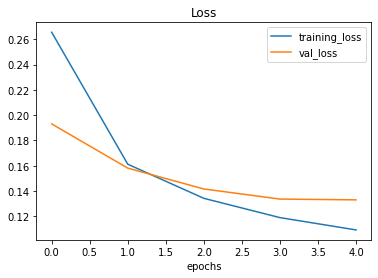

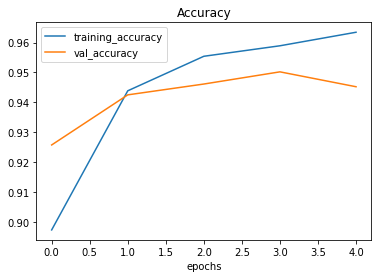

In [15]:
# Check out our model's training curves
plot_loss_curves(model_history)

## Making a prediction with our trained model

To test it out, we'll upload an image and see how the model goes. First, let's remind ourselves of the classnames and view the image we're going to test on.

In [16]:
# Check class names we have
class_names = train_data.class_names
class_names

['covid', 'normal']

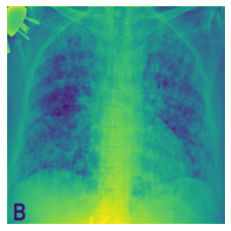

In [17]:
covid_img = mpimg.imread('/content/covid_radiography_all_data/test/covid/COVID-1222.png')
plt.imshow(covid_img)
plt.axis(False);

In [18]:
# Check the image shape
covid_img.shape

(299, 299)

Since our model takes in images of shapes `(224, 224, 3)`, we've got to reshape our custom image to use it with our model.

For model to make predictions on custom data it has to be in the same format that the model has been trained on.

To do so, we can import and decode our image using [`tf.io.read_file`](https://www.tensorflow.org/api_docs/python/tf/io/read_file) (for readining files) and [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) (for resizing our image and turning it into a tensor).

In [19]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, channels=3):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [20]:
covid_img = load_and_prep_image('/content/covid_radiography_all_data/test/covid/COVID-1222.png')
covid_img.shape

TensorShape([224, 224, 3])

Although our image is in the same shape as the images our model has been trained on, we're still missing a dimension.

Our model was trained on data in the shape of
`(batch_size, 224, 224, 3)`.

We can add an extra dimension to our custom image tensor using [`tf.expand_dims`](https://www.tensorflow.org/api_docs/python/tf/expand_dims).

In [21]:
# Add an extra dimension at axis=0
covid_img = tf.expand_dims(covid_img, axis=0)
covid_img.shape

TensorShape([1, 224, 224, 3])

In [22]:
# Make prediction on custom image tensor
covid_pred = model.predict(covid_img)
covid_pred

array([[0.8750202 , 0.12497973]], dtype=float32)

In [23]:
# Predict the class
covid_pred_class = class_names[int(tf.round(covid_pred)[0][0])]
covid_pred_class

'normal'

The model prediction is wrong. Let's visualize it.

In [24]:
# Create function to make prediction and plot image
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

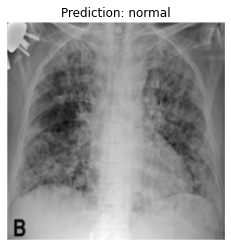

In [25]:
# Test our model on a custom image
pred_and_plot(model=model,
              filename='/content/covid_radiography_all_data/test/covid/COVID-1222.png',
              class_names=class_names)

The model isn't able to predict the image right.

## Fine-tune

Our feature extraction transfer learning model isn't performing well on custom data. We can try to fine-tune a few layers in the base model and see if we gain any improvements?

The `ModelCheckpoint` callback has got the saved weights of our trained model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

Because our data is imbalance, we'll also introduce `class_weights` from [sklearn.utils.class_weight.compute_class_weight](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) to estimate class weights and use them in training.

In [26]:
# Check which layers are tuneable in the model
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 MobilenetV3small False
2 global_average_pooling True
3 output_layer True


In [27]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [28]:
# Check layers in base model (last 10 are trainable)
for layer_num, layer in enumerate(base_model.layers):
    print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 Conv False
3 Conv/BatchNorm False
4 tf.__operators__.add False
5 re_lu False
6 tf.math.multiply False
7 multiply False
8 expanded_conv/depthwise/pad False
9 expanded_conv/depthwise False
10 expanded_conv/depthwise/BatchNorm False
11 re_lu_1 False
12 expanded_conv/squeeze_excite/AvgPool False
13 expanded_conv/squeeze_excite/Conv False
14 expanded_conv/squeeze_excite/Relu False
15 expanded_conv/squeeze_excite/Conv_1 False
16 tf.__operators__.add_1 False
17 re_lu_2 False
18 tf.math.multiply_1 False
19 expanded_conv/squeeze_excite/Mul False
20 expanded_conv/project False
21 expanded_conv/project/BatchNorm False
22 expanded_conv_1/expand False
23 expanded_conv_1/expand/BatchNorm False
24 re_lu_3 False
25 expanded_conv_1/depthwise/pad False
26 expanded_conv_1/depthwise False
27 expanded_conv_1/depthwise/BatchNorm False
28 re_lu_4 False
29 expanded_conv_1/project False
30 expanded_conv_1/project/BatchNorm False
31 expanded_conv_2/expand False
32 expanded_co

In [29]:
# Extract total labels (train + validation)
train_data_classes = []
for images, labels in train_data.unbatch():
    train_data_classes.append(labels.numpy().argmax())

valid_data_classes = []
for images, labels in valid_data.unbatch():
    valid_data_classes.append(labels.numpy().argmax())

total_training_classes = train_data_classes + valid_data_classes
len(total_training_classes)

11045

In [30]:
# Ratio of total_training_classes
covid, normal = np.bincount(total_training_classes)
total = covid + normal
print(f"Examples:\n\t Total: {total}\n\t \
Covid: {covid} ({100*covid/total:,.2f}% of total)\n\t \
Normal: {normal} ({100*normal/total:,.2f}% of total)")

Examples:
	 Total: 11045
	 Covid: 2892 (26.18% of total)
	 Normal: 8153 (73.82% of total)


In [31]:
# Setup class weights to pay more attention to under-represented class
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(total_training_classes),
                                                 total_training_classes)
class_weights = dict(enumerate(class_weights))

print(f'These classes {train_data.class_names[0], train_data.class_names[1]} will get {class_weights} weights respectively')

These classes ('covid', 'normal') will get {0: 1.9095781466113417, 1: 0.6773580277198578} weights respectively


In [32]:
# load and use weights from model checkpoint
model.load_weights(checkpoint_path)

# Recompile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [33]:
# Fine tune model with class weights by training it for further 5 epochs
fine_tune_epochs = INITIAL_EPOCHS + 5

# Fit the class_weights_model
model_history_2 = model.fit(train_data,
                      steps_per_epoch=len(train_data),
                      epochs=fine_tune_epochs,
                      validation_data=valid_data,                                  
                      validation_steps=len(valid_data),
                      initial_epoch=model_history.epoch[-1],
                      class_weight=class_weights)  # add weights

Epoch 5/10
277/277 [==============================] - 37s 111ms/step - loss: 0.1308 - accuracy: 0.9578 - val_loss: 0.1396 - val_accuracy: 0.9484
Epoch 6/10
277/277 [==============================] - 30s 107ms/step - loss: 0.1105 - accuracy: 0.9616 - val_loss: 0.1138 - val_accuracy: 0.9570
Epoch 7/10
277/277 [==============================] - 30s 107ms/step - loss: 0.0907 - accuracy: 0.9715 - val_loss: 0.0966 - val_accuracy: 0.9620
Epoch 8/10
277/277 [==============================] - 30s 107ms/step - loss: 0.0827 - accuracy: 0.9749 - val_loss: 0.1212 - val_accuracy: 0.9570
Epoch 9/10
277/277 [==============================] - 30s 107ms/step - loss: 0.0732 - accuracy: 0.9787 - val_loss: 0.1204 - val_accuracy: 0.9556
Epoch 10/10
277/277 [==============================] - 30s 108ms/step - loss: 0.0646 - accuracy: 0.9823 - val_loss: 0.0815 - val_accuracy: 0.9679


In [34]:
# Evaluate the model after fine-tuned
model_loss_2, model_acc_2= model.evaluate(test_data)

87/87 [==============================] - 8s 86ms/step - loss: 0.0750 - accuracy: 0.9714


Before going ahead, lets save the model first.

In [52]:
# import shutil
# shutil.rmtree('fine_tuned_mobilenetv3small')

In [53]:
model.save('fine_tuned_mobilenetv3small.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Now load the model and re-evaluate it to ensure that the model is saved properly.

In [54]:
model = tf.keras.models.load_model('fine_tuned_mobilenetv3small.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling (Glo  (None, 1024)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 2)                 2050      
                                                                 
Total params: 1,532,018
Trainable params: 592,898
Non-trainable params: 939,120
_________________________________________________________________


In [55]:
loaded_model_loss, loaded_model_acc = model.evaluate(test_data)

87/87 [==============================] - 9s 90ms/step - loss: 0.0750 - accuracy: 0.9714


It seems like our model got a slight boost from fine-tuning.

We might get a better picture by comparing histories before and after fine-tune and see what the training curves say.

In [56]:
# Create function to compare histories before and after fine-tuning
def compare_histories(original_history, new_history, INITIAL_EPOCHS=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    print(len(acc))
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    # Combine original history with new history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']
    
    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']
    
    print(len(total_acc))
    print(total_acc)
    
    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1],
            plt.ylim(), label='Start Fine Tuning')  # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.8973517417907715, 0.9438660144805908, 0.9554097056388855, 0.958918035030365, 0.9634450078010559, 0.9577863216400146, 0.9616342186927795, 0.9714803099632263, 0.9748755097389221, 0.978723406791687, 0.982344925403595]


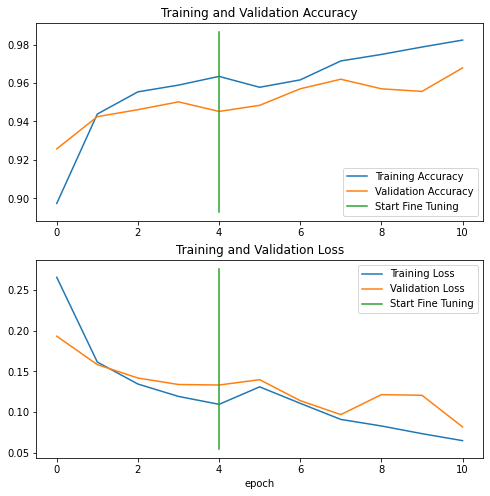

In [57]:
# Check the histories
compare_histories(original_history=model_history,
                 new_history=model_history_2)

Seems like the curves are heading in the right direction after fine-tuning.

## Make predictions on test data

In [58]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)

87/87 [==============================] - 9s 89ms/step


In [59]:
# How many predictions are there?
len(pred_probs)

2763

In [60]:
# How do they look?
pred_probs[:10]

array([[9.9991000e-01, 8.9979403e-05],
       [9.9934500e-01, 6.5497309e-04],
       [4.0557820e-01, 5.9442180e-01],
       [9.9169511e-01, 8.3049405e-03],
       [9.9751782e-01, 2.4822522e-03],
       [5.2454698e-01, 4.7545305e-01],
       [3.1421369e-01, 6.8578631e-01],
       [9.2216808e-01, 7.7831924e-02],
       [9.9933630e-01, 6.6363846e-04],
       [9.9987435e-01, 1.2566806e-04]], dtype=float32)

For each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for covid and normal class.

The index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [61]:
# Get the class prediction of each label (there are 2763 in total)
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

**Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [62]:
# Unravelling the test_data batches
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [63]:
len(y_labels)

2763

## Evaluating models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [64]:
# Get accuracy score by comparing predicted classes to ground truth labels
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.9714078899746652

Visualize the performance with a confusion matrix. To do so, we'll create `make_confusion_matrix` function.

In [65]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(8,8), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used.

    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                              y_pred=y_preds, # predicted labels
                              classes=class_names, # array of class label names
                              figsize=(15, 15),
                              text_size=10)
    """  
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with
    
    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Check if there is a list of classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title='Confusion Matrix',
          xlabel='Predicted label',
          ylabel='True label',
          xticks=np.arange(n_classes),  # create enough axis slots for each class
          yticks=np.arange(n_classes),
          xticklabels=labels,  # axes will labeled with class names (if they exist) or ints
          yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    
    # Set font size
    plt.xticks(fontsize=text_size)
    plt.yticks(fontsize=text_size)
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f'{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)',
                    horizontalalignment='center',
                    color='white' if cm[i, j] > threshold else 'black',
                    size=text_size)
        else:
            plt.text(j, i, f'{cm[i, j]}',
                    horizontalalignment='center',
                    color='white' if cm[i, j] > threshold else 'black',
                    size=text_size)
    
    # Save the figure to the current working directory
    if savefig:
        fig.savefig('confusion_matrix.png')

Right now our predictions and truth labels are in the form of integers, however, they'll be much easier to understand if we get their actual names. We can do so using the `class_names` attribute on our `test_data` object.

In [66]:
# Get the class names
class_names = test_data.class_names
class_names

['covid', 'normal']

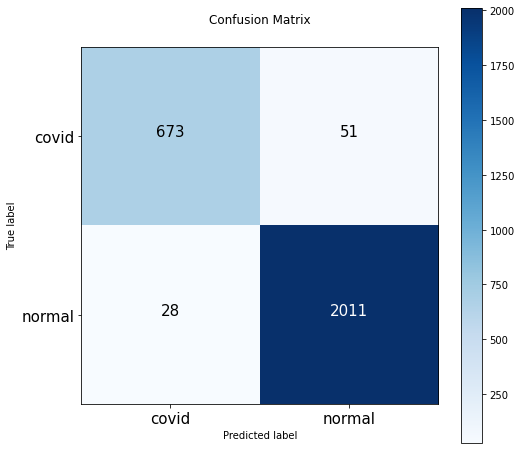

In [67]:
# Plot a confusion matrix
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     classes=class_names,
                     savefig=True)

The good news is, the majority of the predictions are in diagonal, meaning they're correct.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.

In [68]:
# Check classification report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       724
           1       0.98      0.99      0.98      2039

    accuracy                           0.97      2763
   macro avg       0.97      0.96      0.96      2763
weighted avg       0.97      0.97      0.97      2763



The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

Let's make it easier to understand with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [69]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.944561403508772,
  'precision': 0.9600570613409415,
  'recall': 0.9295580110497238,
  'support': 724},
 '1': {'f1-score': 0.980736405754694,
  'precision': 0.975266731328807,
  'recall': 0.9862677783227072,
  'support': 2039},
 'accuracy': 0.9714078899746652,
 'macro avg': {'f1-score': 0.962648904631733,
  'precision': 0.9676618963348742,
  'recall': 0.9579128946862154,
  'support': 2763},
 'weighted avg': {'f1-score': 0.9712573244568122,
  'precision': 0.9712812803439302,
  'recall': 0.9714078899746652,
  'support': 2763}}

Alright, there's a fair few values here, how about we narrow down? 

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [70]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
    if k=='accuracy':  # stop once get to accuracy key
        break
    else:
        # add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'covid': 0.944561403508772, 'normal': 0.980736405754694}

Turn our `class_f1_scores` dictionary into a pandas DataFrame.

In [71]:
f1_scores = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                         'f1-score': list(class_f1_scores.values())})

f1_scores

,class_name,f1-score
0,covid,0.944561
1,normal,0.980736


Let's visualize the classes with horizontal bar chart

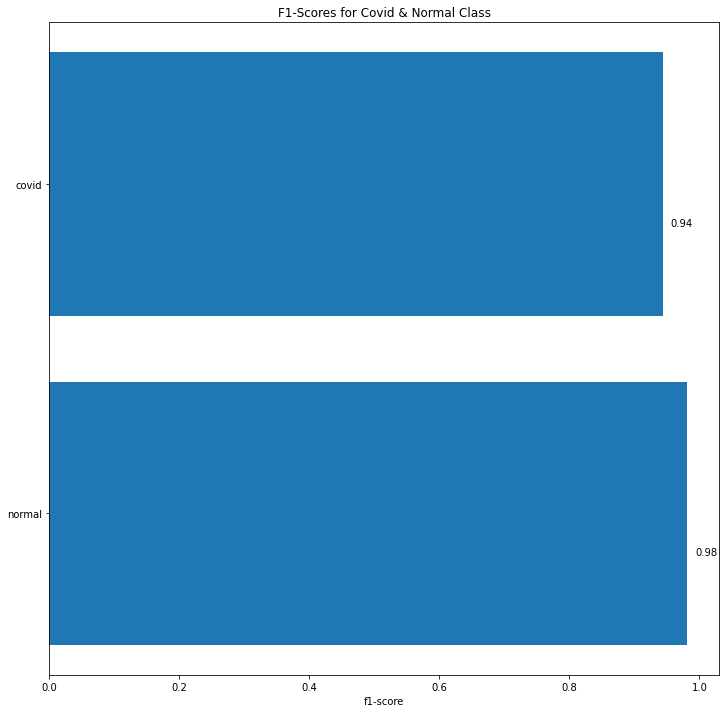

In [72]:
fig, ax = plt.subplots(figsize=(12,12))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('F1-Scores for Covid & Normal Class')
ax.invert_yaxis();  # reverse the order

def autolabel(rects):  # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height (it's value).
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
               f'{width:.2f}',
               ha='center', va='bottom')

autolabel(scores)

## Visualize predictions on evaluation images

Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [73]:
def load_and_prep_image(filename, img_shape=224, channels=3, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into
    (224, 224, 3).

    Parameters
    ----------
    filename (str): string filename of target image
    img_shape (int): size to resize target image to, default 224
    scale (bool): whether to scale pixel values to range(0, 1), default True
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_image(img, channels)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    
    if scale:
        # Rescale the image
        return img/255.
    else:
        return img

Now let's write some code to: 

1. Load a few random images from the test/evaluation dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

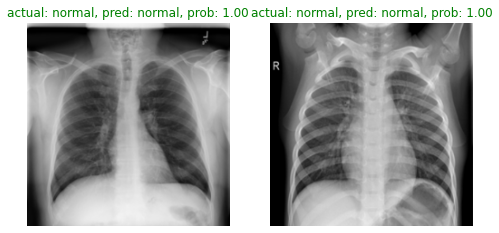

In [74]:
plt.figure(figsize=(8,8))
for i in range(2):
    # Choose a random image from a random class
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + '/' + class_name))
    filepath = test_dir + '/' + class_name + '/' + filename
    
    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)  # no need to scale images for MobileNet predictions
    pred_prob = model.predict(tf.expand_dims(img, axis=0))  # # model accepts tensors of shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()]  # find the predicted class
    
    # Plot the image(s)
    plt.subplot(1, 2, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:  # Change the color of text based on whether prediction is right or wrong
        title_color = 'g'
    else:
        title_color = 'r'
    
    plt.title(f'actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
    plt.axis(False);

## Finding the most wrong predictions

It's a good idea to go through few random instances of the model's predictions to get a good feel for how it's doing.

After a while we might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These **most wrong** predictions can help to give further insight into the model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:
1. Get all of the image file paths in the test dataset using the [`list_files()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
  * **Note:** We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [75]:
# 1. Get the filenames of all our test data
filepaths = []
for filepath in test_data.list_files(test_dir + '/*/*.png',
                                    shuffle=False):
    filepaths.append(filepath.numpy().decode('utf-8'))

filepaths[:10]

['covid_radiography_all_data/test/covid/COVID-10.png',
 'covid_radiography_all_data/test/covid/COVID-100.png',
 'covid_radiography_all_data/test/covid/COVID-1003.png',
 'covid_radiography_all_data/test/covid/COVID-1005.png',
 'covid_radiography_all_data/test/covid/COVID-101.png',
 'covid_radiography_all_data/test/covid/COVID-1010.png',
 'covid_radiography_all_data/test/covid/COVID-1018.png',
 'covid_radiography_all_data/test/covid/COVID-1021.png',
 'covid_radiography_all_data/test/covid/COVID-1024.png',
 'covid_radiography_all_data/test/covid/COVID-1027.png']

We've got all of the test image filepaths, let's combine them into a DataFrame along with:
* Their ground truth labels (`y_labels`).
* The class the model predicted (`pred_classes`).
* The maximum prediction probabilitity value (`pred_probs.max(axis=1)`).
* The ground truth class names.
* The predicted class names. 

In [76]:
# 2. Create a DataFrame out of current prediction data for analysis
pred_df = pd.DataFrame({'img_path': filepaths,
                       'y_true': y_labels,
                       'y_pred': pred_classes,
                       'pred_conf': pred_probs.max(axis=1),  # get the maximum prediction probability value
                       'y_true_classname': [class_names[i] for i in y_labels],
                       'y_pred_classname': [class_names[i] for i in pred_classes]})

pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.999910,covid,covid
1,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.999345,covid,covid
2,covid_radiography_all_data/test/covid/COVID-10...,0,1,0.594422,covid,normal
3,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.991695,covid,covid
4,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.997518,covid,covid


We now make a simple column telling us whether or not the prediction is right or wrong?

In [77]:
# Is the prediction correct?
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.999910,covid,covid,True
1,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.999345,covid,covid,True
2,covid_radiography_all_data/test/covid/COVID-10...,0,1,0.594422,covid,normal,False
3,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.991695,covid,covid,True
4,covid_radiography_all_data/test/covid/COVID-10...,0,0,0.997518,covid,covid,True


And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the "all of the wrong" predictions and sort these wrong predictions in descending order for prediction probabilties?

In [78]:
# Get all of the  wrong examples
wrong_pred = pred_df[pred_df['pred_correct'] == False].sort_values('pred_conf', ascending=False)
wrong_pred.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
262,covid_radiography_all_data/test/covid/COVID-21...,0,1,0.988521,covid,normal,False
468,covid_radiography_all_data/test/covid/COVID-30...,0,1,0.982603,covid,normal,False
1562,covid_radiography_all_data/test/normal/Normal-...,1,0,0.969279,normal,covid,False
186,covid_radiography_all_data/test/covid/COVID-18...,0,1,0.965189,covid,normal,False
807,covid_radiography_all_data/test/normal/Normal-...,1,0,0.957499,normal,covid,False
2477,covid_radiography_all_data/test/normal/Normal-...,1,0,0.945929,normal,covid,False
184,covid_radiography_all_data/test/covid/COVID-18...,0,1,0.933320,covid,normal,False
373,covid_radiography_all_data/test/covid/COVID-26...,0,1,0.930178,covid,normal,False
528,covid_radiography_all_data/test/covid/COVID-33...,0,1,0.923912,covid,normal,False
172,covid_radiography_all_data/test/covid/COVID-17...,0,1,0.919964,covid,normal,False


Just by comparing the ground truth classname (`y_true_classname`) and the prediction classname column (`y_pred_classname`), we can notice the trends in the numbers.

It might be easier if we visualize them.

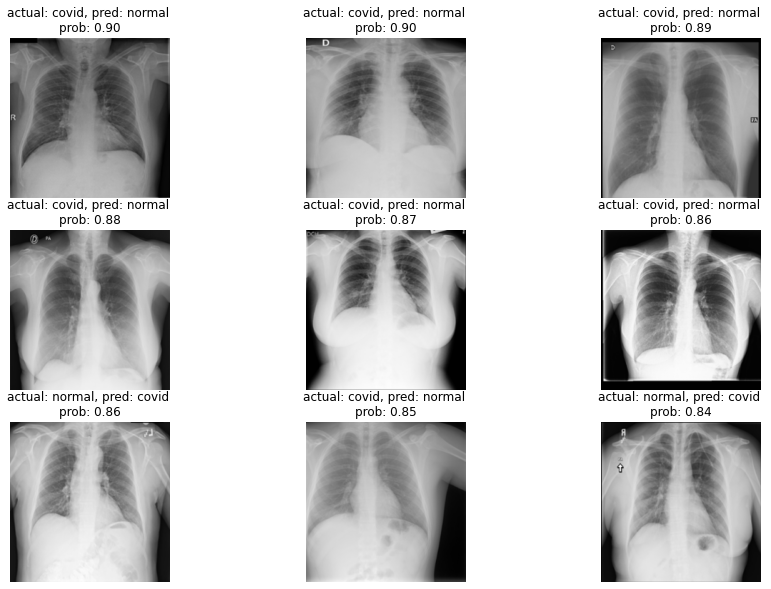

In [79]:
# Visualize some of the most wrong examples
images_to_view = 9
start_index = 10  # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(wrong_pred[start_index:start_index+images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=True)
    _, _, _, _, pred_prob, y_true, y_pred, _ = row  # only interested in specified parameters of each row
    plt.imshow(img)
    plt.title(f'actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}')
    plt.axis(False)

Going through the model's most wrong predictions can usually help to figure out a couple of things:
* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as [**active learning**](https://blog.scaleway.com/active-learning-some-datapoints-are-more-equal-than-others/).
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the model on test images as well as custom images

So far we've visualized some our model's predictions from the test dataset but it's time for the real test: using our model to make predictions on our own custom images of covid_normal CXR.

For this we want to upload own images first or to load into the notebook.

Once the images are uploaded, we can load these in and turn them into tensors using our `load_and_prep_image()` function but first we need a list of image filepaths.

In [80]:
# Import data and unzip it
ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/covid_ready_dataset/custom_covid_xrays.zip')
ref.extractall()
ref.close()

In [81]:
# Get custom images filepaths
custom_xrays_images = ['custom_covid_xrays/' + img_path for img_path in os.listdir('custom_covid_xrays/')]
custom_xrays_images

['custom_covid_xrays/017.jpeg',
 'custom_covid_xrays/014.jpeg',
 'custom_covid_xrays/015.jpeg',
 'custom_covid_xrays/022.jpeg',
 'custom_covid_xrays/024.jpeg',
 'custom_covid_xrays/04.jpeg',
 'custom_covid_xrays/025.jpeg',
 'custom_covid_xrays/015.jpg',
 'custom_covid_xrays/016.jpeg',
 'custom_covid_xrays/03.jpeg',
 'custom_covid_xrays/01.jpeg',
 'custom_covid_xrays/013.jpeg',
 'custom_covid_xrays/08.jpeg',
 'custom_covid_xrays/021.jpeg',
 'custom_covid_xrays/09.jpeg',
 'custom_covid_xrays/020.jpg',
 'custom_covid_xrays/02.jpeg',
 'custom_covid_xrays/012.jpeg',
 'custom_covid_xrays/07.jpeg',
 'custom_covid_xrays/06.jpeg',
 'custom_covid_xrays/05.jpeg',
 'custom_covid_xrays/011.jpeg',
 'custom_covid_xrays/019.png',
 'custom_covid_xrays/010.jpeg',
 'custom_covid_xrays/010.png',
 'custom_covid_xrays/04.png',
 'custom_covid_xrays/07.jpg',
 'custom_covid_xrays/09.png']

Now we can use similar code to what we used previously to load in our images, make a prediction on each using our trained model and then plot the image along with the predicted class.

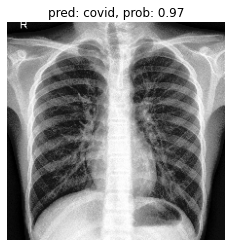

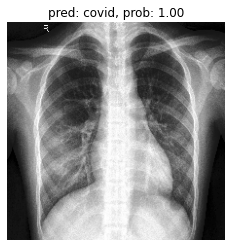

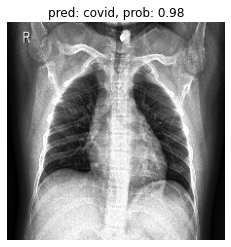

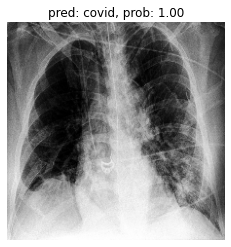

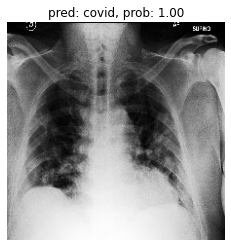

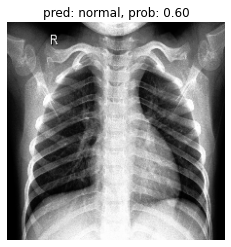

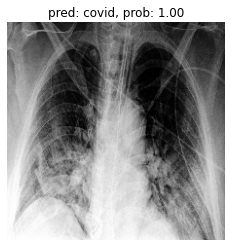

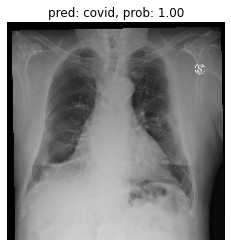

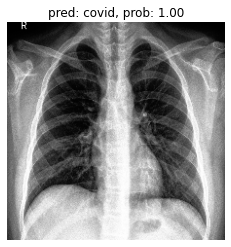

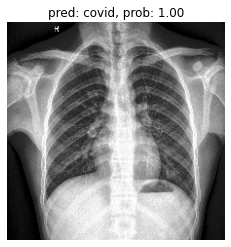

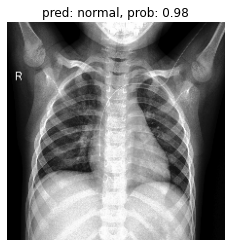

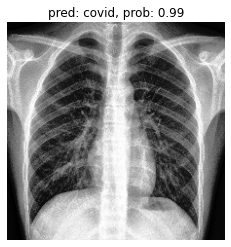

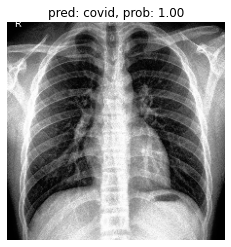

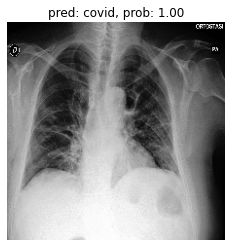

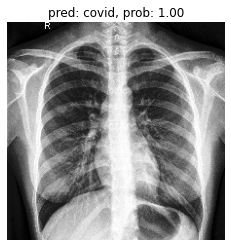

In [82]:
# Make predictions on first 15 custom xrays images
for img in custom_xrays_images[:15]:
    img = load_and_prep_image(img, scale=False)  # load in target image and turn it into tensor
    pred_prob = model.predict(tf.expand_dims(img, axis=0))  # make prediction on image with shape [None, 224, 224, 3]
    pred_class = class_names[pred_prob.argmax()]  # find the predicted class label
    
    # Plot the images with appropriate annotations
    plt.figure()
    plt.imshow(img/255.)  # imshow() requires float inputs to be normalized
    plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}')
    plt.axis(False)

## Conclusion

Although the models accuracy and predictions are quite good but by no means it should be implemented in the real-world applications. These experiments are done without any supervision of madical researchers/practitioner, therefore we can not claim how efficient the model is real-world scenario.

Head over to the [paper](https://www.sciencedirect.com/science/article/pii/S001048252100113X?via%3Dihub) for full insights.